In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
# view the keys for 70,000 images with 784 features
# 28 x 28 px
# pixel intensity from 0 to 255
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

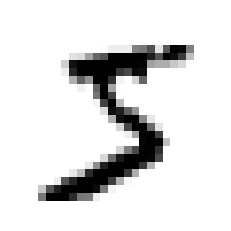

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap ="binary")
plt.axis("off")
plt.show()

In [4]:
import numpy as np
# cast data to int
y = y.astype(np.uint8)

# split train and test (data already shuffled)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
# training binary classifier -- split data
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [6]:
# training binary classifier -- load model (linear)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

#startified sampling
skflods = StratifiedKFold(n_splits=3, random_state=42)

#similar to cross_val_score()
for train_index, test_index in skflods.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


In [15]:
# verify custom validator is working 
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])